# MarginalLogDensities.jl Demo

This notebook shows a simple demo of `MarginalLogDensities`, the proof-of-concept Julia package I've been working on to enable fitting statistical models while integrating out arbitrary subsets of variables a la TMB.  The source code for the package is here:

https://github.com/ElOceanografo/MarginalLogDensities.jl

It's a pretty straightforward implementation using the tools currently available in Julia. I haven't put much work into benchmarking or optimizing the code, so it could probably be made much more efficient with some dedicated effort.  I also haven't tested it on any problems more complicated than the one below, so no guarantees it won't choke on more serious models.  Still, it already has basic versions of the following features of TMB:

1. It works, in theory, on any log-density function coded in Julia,
2. It can integrate out arbitrary sets of parameters,
3. It has an implementation of the Laplace approximation, which
4. Derives a sparse Hessian automatically using AD and sparsity-detection.  This one is a little hacky and suboptimal, but it works, and is at least a starting point for improvement.

The following demo shows its usage. This example is a simple hierarchical linear regression, where `y` is a function of a continuous variable `x` and a categorical variable `category` with 8 levels.  The slope of the regression is the same for all groups, but each group has its own intercept `a`.  Those intercepts, in turn, are drawn from a normal distribution with hyperparameters `μ0` and `σ0`.

$$
y_i \sim \mathrm{Normal}(a[C_i] + b x_i, \sigma) \\
\mathbf{a} = \{a_1, a_2, ..., a_C\} \\
a_i \sim \mathrm{Normal}(\mu_0, \sigma_0) \\
$$

Our goal is to fit $b$, $\sigma$, $\mu_0$, and $\sigma_0$ while marginalizing out all the category-specific intercepts in $\mathbf{a}$.

Simulating and plotting this dataset:

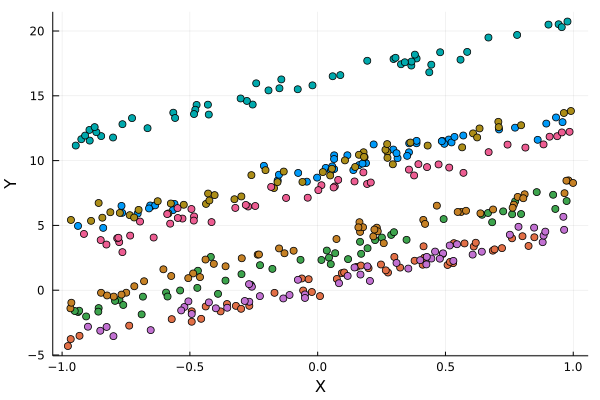

In [1]:
using MarginalLogDensities
using Distributions
using StatsPlots
using Random
using Optim
using BenchmarkTools

Random.seed!(1234)

# Defining the true values of the parameters
ncategories = 8
categories = 1:ncategories
μ0 = 5.0
σ0 = 5.0
aa = rand(Normal(μ0, σ0), ncategories)
b = 4.5
σ = 0.5

# Defining the covariates
const category = repeat(categories, inner=50)
const n = length(category)
const x = rand(Uniform(-1, 1), n)

# Calculate the mean of the response variable and simulate from it
μ = [aa[category[i]] + b * x[i] for i in 1:n]
const y = rand.(Normal.(μ, σ))

scatter(x, y, color=category, label="", xlabel="X", ylabel="Y")

Next, we'll code up a log-likelihood function.  For simplicity, we won't put priors on any of the parameters.  

(NB: The function uses the variables `x`, `category`, `y`, and `n`, which are all defined in the global scope.  Global variables are a common performance-killer in Julia.  There are more elegant ways to avoid using global variables, but for simplicity of presentation, I left them as globals while declaring them constant in the first code block. This lets the compiler know their values won't change so it can generate fast machine code.)

In [2]:
function loglik(θ::Vector{T}) where T
    # unpack parameter vector θ, and transform the nonnegative parameters using exp()
    μ0 = θ[1]
    σ0 = exp(θ[2])
    aa = θ[3:10]
    b = θ[11]
    σ = exp(θ[12])
    # predict the mean of the response conditional on the parameters
    μ = [aa[category[i]] + b * x[i] for i in 1:n]
    # return the log-likelihood of `aa` and `y`
    return loglikelihood(Normal(μ0, σ0), aa) + sum(logpdf.(Normal.(μ, σ), y))
end

loglik (generic function with 1 method)

This is the "template" function.  We'll make sure it runs by putting the true parameter values into a vector and calculating their log-likelihood:

In [3]:
θtrue = [μ0; log(σ0); aa; b; log(σ)]
loglik(θtrue)

-305.32773429610984

Next we'll constuct a `MarginalLogDensity` object to integrate out the random effect `aa`.  This is a type which will wrap `loglik` and stores the total number of parameters, as well as the indices of the parameters we want to marginalize out.  Once it's constructed we can call it like a function.  As we've set up our loglikelihood function, `aa` occupies indices 3:10 of the parameter vector.

In [4]:
nθ = length(θtrue)
imarg = collect(3:10)
mld = MarginalLogDensity(loglik, nθ, imarg)

MarginalLogDensity{Int64, LaplaceApprox, Vector{Int64}, typeof(loglik)}(loglik, 12, [3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 11, 12], LaplaceApprox())

This new object `mld` now acts like a function.  We can call it with two arguments, representing the fixed and random effect parameters, in which case it returns the same value as our original function `loglik`.

In [5]:
mld(aa, [μ0, log(σ0), b, log(σ)])

-305.32773429610984

Alternatively, we can call it with *just* the fixed-effect parameters, in which case it returns their log-density after integrating out the random effects.  By default this uses the Laplace approximation, though the package also has an option to do it using numerical cubature (more accurate, but not practical for more than a few variables due to the curse of dimensionality).

In [6]:
mld([μ0, log(σ0), b, log(σ)])

-316.2530991948884

Now that we've got this marginal log-density object, we optimize it using whatever method we'd like.  Here we'll use the general-purpose `optimize` from Julia's Optim.jl library.  Note that `mld` returns a *positive* log-likelihood, so we use an anonymous function to reverse the sign when passing it to `optimize` (which looks for a function minimum).  We give the parameter vector an initial value of `ones(m)`.  By default it uses a Nelder-Mead algorithm, though many others are available.

In [7]:
m = nθ - length(imarg)
opt = optimize(θjoint -> -mld(θjoint), ones(m))

 * Status: success

 * Candidate solution
    Final objective value:     3.158321e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    206
    f(x) calls:    367


Note that the final objective value is close to the marginal value for the true parameters in the cell above.  Next, we'll unpack the optimized parameters and calculate the Hessian of the loglikelihood at the optimum.  Because AD has trouble differentiating through the call to `optimize` going on inside the Laplace approximation in `mld`, we'll just use finite differences.

In [8]:
μ0_opt, logσ0_opt, b_opt, logσ_opt = opt.minimizer
θ_opt = [μ0_opt, exp(logσ0_opt), b_opt, exp(logσ_opt)]

using FiniteDiff, LinearAlgebra
H = FiniteDiff.finite_difference_hessian(θjoint -> -mld(θjoint), opt.minimizer)
std_errors = 1 ./ sqrt.(diag(H))

4-element Vector{Float64}:
 1.780641026904739
 0.25013970155786147
 0.04429993253160354
 0.03571467801662579

Finally, we can plot the solutions +/- two standard errors, along with the true values of each parameter.

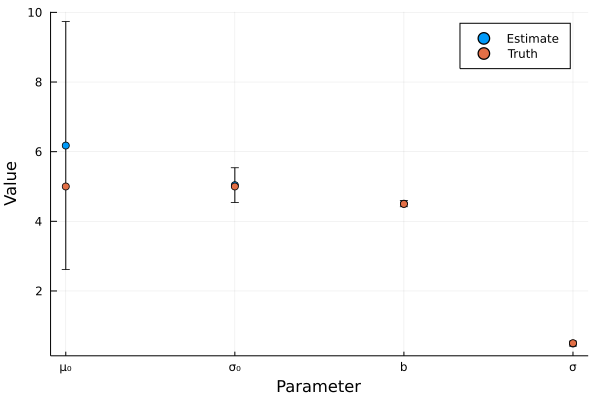

In [9]:
θ_names = ["μ₀", "σ₀", "b", "σ"]
scatter(θ_names, θ_opt, yerror=2*std_errors, label="Estimate",
    xlabel="Parameter", ylabel="Value")
scatter!(θ_names, [μ0, σ0, b, σ], label="Truth")